# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [287]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import project_tests as t

import itertools
from difflib import SequenceMatcher

In [222]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### Load user-item interactions file

In [296]:
df = pd.read_csv('data/user-item-interactions.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


#### Check number of unique users

In [297]:
df.email.unique().shape[0]

5149

#### There are missing emails

In [298]:
df[df.email.isnull()]

,article_id,title,email
25131,1016.0,why you should master r (even if it might even...,NaN
29758,1393.0,the nurse assignment problem,NaN
29759,20.0,working interactively with rstudio and noteboo...,NaN
29760,1174.0,breast cancer wisconsin (diagnostic) data set,NaN
29761,62.0,data visualization: the importance of excludin...,NaN
35264,224.0,"using apply, sapply, lapply in r",NaN
35276,961.0,beyond parallelize and collect,NaN
35277,268.0,sector correlations shiny app,NaN
35278,268.0,sector correlations shiny app,NaN
35279,268.0,sector correlations shiny app,NaN


#### Load contents file

In [299]:
df_content = pd.read_csv('data/articles_community.csv')
df_content.drop('Unnamed: 0', axis=1, inplace=True)
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

#### There are 5148 unique users with valid emails and 17 null emails that are grouped as a single email.

In [348]:
total_email_entries = df.email.unique().shape[0] 
null_email_entries = df[df.email.isnull()].shape[0]
print('Total email entries: ', total_email_entries)
print('Null email entries: ', null_email_entries)
print('Valid users: ', total_email_entries - 1)

Total email entries:  5149
Null email entries:  17
Valid users:  5148


In [349]:
df.dropna(inplace=True)

#### 50% of users interact with 3 articles. Outliers interacted with as many as 364 articles. 

In [302]:
df_ = df.groupby('email').agg({'article_id':'size'})\
.rename(columns={'article_id':'number_articles'})
df_.describe()

,number_articles
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


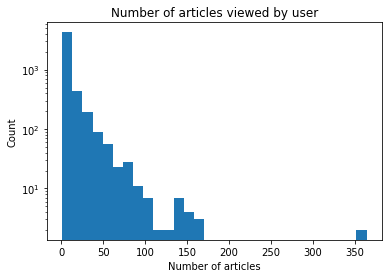

In [303]:
plt.hist(df_.number_articles, bins=30, log=True)
plt.xlabel('Number of articles')
plt.ylabel('Count')
plt.title('Number of articles viewed by user');
#df_.number_articles.hist(bins=30, log=True)

In [304]:
# Fill in the median and maximum number of user_article interactios below

median_val = df_.median()[0] # 50% of individuals interact with _ number of articles or fewer.
max_views_by_user = df_.max()[0] # The maximum number of user-article interactions by any 1 user is _.
median_val, max_views_by_user

(3.0, 364)

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

#### No obvious duplicates. Shape is the same after drop_duplicates

In [305]:
df_content.shape, df_content.drop_duplicates().shape

((1056, 5), (1056, 5))

#### There are article_id duplicates

In [306]:
df_content.drop_duplicates(subset=['article_id']).shape

(1051, 5)

#### All were dropped except for the first occurrence

In [307]:
df_content.drop_duplicates(subset=['article_id'], inplace=True)

#### I can also see that articles 1 and 4 are close

In [308]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


#### They are 40% similar. Is that sufficient to consider them duplicates? I consider not.

In [165]:
SequenceMatcher(None, df_content.doc_body[0], df_content.doc_body[4]).ratio()

0.39732239257179874

#### Are there any highly-similar pairs?

In [212]:
combinations = list(itertools.combinations(df_content.index, 2))
#match_dict = {comb: SequenceMatcher(None, df_content.doc_body[comb[0]], df_content.doc_body[comb[1]]).ratio() for comb in combinations}
match_list = [{'element_1':comb[0], 'element_2':comb[1], 'ratio': SequenceMatcher(None, df_content.doc_body[comb[0]], df_content.doc_body[comb[1]]).ratio()} for comb in combinations]

In [220]:
df_match = pd.DataFrame(match_list)
display(df_match[df_match.ratio==1].shape)
df_match[df_match.ratio==1]

(100, 3)

,element_1,element_2,ratio
34456,33,369,1.0
34970,33,885,1.0
35103,33,1020,1.0
195254,206,276,1.0
195461,206,484,1.0
195485,206,508,1.0
195517,206,540,1.0
195615,206,638,1.0
195644,206,667,1.0
195682,206,706,1.0


In [241]:
df_content[df_content.article_id==3]['doc_body'].values

array(["DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCALE - BOOST THE PERFORMANCE OF YOUR\r\nDISTRIBUTED DATABASE\r\nShare on Twitter Share on Facebook Share on Google+ Vote on Hacker News Published Dec 29, 2016Learn how distributed DBs (Cassandra, MongoDB, RethinkDB, etc) solve the problem\r\nof scaling persistent storage, but introduce latency as data size increases and\r\nbecome I/O bound. In single server DBs, latency is solved by introducing\r\ncaching. In this talk, Akbar Ahmed shows you how to improve the performance of\r\ndistributed DBs by using a distributed cache to move the data layer performance\r\nlimitation from I/O bound to network bound.\r\n\r\nAkbar is the CEO and founder of DynomiteDB, a framework for turning single\r\nserver data stores into linearly scalable, distributed databases. He is an\r\nApache Cassandra certified developer and a Cassandra MVP, enjoys the\r\nexpressiveness of both SQL and alternative query languages, and evaluates the\r\nentire database ecosys

In [242]:
df_content[df_content.article_id==369]['doc_body'].values

array(['Homepage Follow Sign in / Sign up Homepage * Home\r\n * Data Science Experience\r\n * \r\n * Watson Data Platform\r\n * \r\n\r\nArmand Ruiz Blocked Unblock Follow Following Lead Product Manager Data Science Experience #IBM #BigData #Analytics #RStats\r\n#Cloud - Born in Barcelona Living in Chicago - All tweets and opinions are my\r\nown Aug 15, 2016\r\n--------------------------------------------------------------------------------\r\n\r\nUPLOAD DATA AND CREATE DATA FRAMES IN JUPYTER NOTEBOOKS\r\nWhen you create an account in IBM Data Science Experience we provision a free\r\nApache Spark Cluster and 5 GB of Free IBM Object Storage . Some of our users shared that they are having trouble loading data in\r\nnotebooks due to inexperience working with Cloud Data Services. Most of them are\r\nused to working with data hosted on their own laptop. We want to provide for you\r\nthe easiest experience to work with your data, and with the tools and libraries\r\nthat you already know.\r\n

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

#### Number of unique articles that have an interaction with a user: 714


In [324]:
df_merge = df.merge(df_content, left_on='article_id', right_on='article_id', how='left')
display(df_merge.isnull().values.any())
unique_articles = df_merge.article_id.unique().shape[0]
unique_articles

True

714

#### Number of unique articles in dataset: 1051

In [327]:
total_articles = df_content.article_id.unique().shape[0]
total_articles

1051

#### Number of unique users in dataset: 5148 counting null

In [350]:
unique_users = df.email.unique().shape[0]
unique_users

5148

#### Number of user-article interactions in dataset: 45993

In [329]:
user_article_interactions = df_merge.shape[0]
user_article_interactions

45993

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

#### Top 5 most viewed articles were 43, 151, 124, 390, 20

In [334]:
top5 = df_merge.groupby('article_id').agg({'email':'size'}).sort_values('email', ascending=False).\
reset_index().head()
top5

,article_id,email
0,1429.0,937
1,1330.0,927
2,1431.0,671
3,1427.0,643
4,1364.0,627


In [346]:
most_viewed_article_id = str(top5.iloc[0,0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = top5.iloc[0,1] # The most viewed article in the dataset was viewed how many times?

In [343]:
df_merge.head()

,article_id,title,email,user_id,doc_body,doc_description,doc_full_name,doc_status
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7,0,NaN,NaN,NaN,NaN
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b,1,NaN,NaN,NaN,NaN
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074,2,NaN,NaN,NaN,NaN
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7,3,NaN,NaN,NaN,NaN
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2,4,NaN,NaN,NaN,NaN


In [315]:
user_dict = {email:i for i, email in enumerate(df.email.unique())}
df['user_id'] = df.email.apply(lambda x: user_dict[x])

In [352]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell


sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [400]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    list_top = df.\
    groupby('article_id').\
    agg({'email':'size'}).\
    sort_values('email', ascending=False).\
    reset_index().iloc[0:n,0].values

    return df[df.article_id.isin(list_top)]['title'].values

In [401]:
print(get_top_articles(10, df))

['healthcare python streaming application demo'
 'use deep learning for image classification'
 'use deep learning for image classification' ...
 'insights from new york car accident reports'
 'visualize car data with brunel'
 'insights from new york car accident reports']


In [374]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    return df.\
        groupby('article_id').\
        agg({'email':'size'}).\
        sort_values('email', ascending=False).reset_index().iloc[0:n,0].values

In [402]:
print(get_top_article_ids(10))

[1429. 1330. 1431. 1427. 1364. 1314. 1293. 1170. 1162. 1304.]
